<a href="https://colab.research.google.com/github/Rupkatha-dev/Task1-IIT-G-/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

Load and Preprocess the CIFAR-10 Dataset

In [2]:
# Transform: Convert to Tensor and Normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 44.7MB/s] 


In [4]:
# CIFAR-10 Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Define the CNN Model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # input channels=3 (RGB)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)                # pooling layer

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)         # after 2 pooling layers
        self.fc2 = nn.Linear(512, 10)                 # 10 classes

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   # Conv1 → ReLU → Pool
        x = self.pool(self.relu(self.conv2(x)))   # Conv2 → ReLU → Pool
        x = x.view(-1, 64 * 8 * 8)                # Flatten
        x = self.dropout(self.relu(self.fc1(x)))  # FC1 → ReLU → Dropout
        x = self.fc2(x)                           # FC2 (output layer)
        return x

# Instantiate Model
net = CNN()

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move CNN model to GPU/CPU
net = net.to(device)

Using device: cuda


Define Loss Function and Optimizer

In [6]:
criterion = nn.CrossEntropyLoss()          # good for multi-class classification
optimizer = optim.Adam(net.parameters(), lr=0.001)


Train the CNN

In [8]:
epochs = 5  # you can increase to get better accuracy

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Finished ✅")


Epoch 1, Loss: 1.3914
Epoch 2, Loss: 1.0303
Epoch 3, Loss: 0.8891
Epoch 4, Loss: 0.7849
Epoch 5, Loss: 0.6986
Training Finished ✅


Test the Model

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) 
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)  # pick highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on 10000 test images: {100 * correct / total:.2f}%")


Accuracy on 10000 test images: 69.85%


Predict on Sample Images

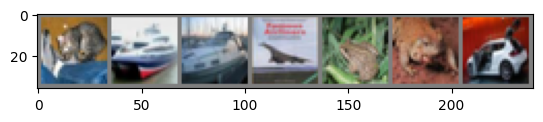

GroundTruth:  cat ship ship plane frog frog car
Predicted:    cat ship ship ship cat frog car


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images (must stay on CPU for matplotlib)
imshow(torchvision.utils.make_grid(images[:7]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(7)))

# Move images to device for prediction
outputs = net(images[:7].to(device))

# Get predicted labels
_, predicted = torch.max(outputs, 1)

# Move predictions back to CPU for printing
print('Predicted:   ', ' '.join(f'{classes[predicted[j].item()]}' for j in range(7)))


Define AlexNet Model

In [12]:
class alexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(alexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate model
alexnet= alexNet(num_classes=10)
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to GPU/CPU
alexnet = alexnet.to(device)


Using device: cuda


Define Loss Function and Optimize

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)


Train AlexNet

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

epochs = 5  # keep small for testing
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Finished ✅")


Epoch 1, Loss: 1.4688
Epoch 2, Loss: 1.0244
Epoch 3, Loss: 0.8547
Epoch 4, Loss: 0.7456
Epoch 5, Loss: 0.6726
Training Finished ✅


Test Accuracy

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on 10000 test images: {100 * correct / total:.2f}%")


Accuracy on 10000 test images: 72.41%


Prediction on Sample Images

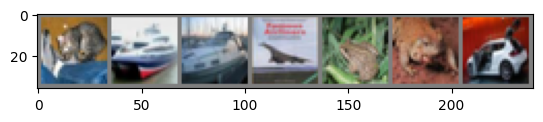

GroundTruth:  cat ship ship plane frog frog car
Predicted:    cat ship ship plane frog frog dog


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images (must be on CPU for matplotlib)
imshow(torchvision.utils.make_grid(images[:7]))

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(7)))

# Send images to GPU for prediction
outputs = alexnet(images[:7].to(device))

# Get predicted labels
_, predicted = torch.max(outputs, 1)

# Move predictions back to CPU for printing
print('Predicted:   ', ' '.join(f'{classes[predicted[j].item()]}' for j in range(7)))
